# Hockey Statistics Database Project

In this notebook I will build a database of hockey statistics that I can use for analytics. Just to specify a concrete goal, I will consider the database project successful if I can use it to calculate corsi close statistics for both teams and players. The corsi close statistic is a the percentage of the shots, missed shots, and blocked shots a team or player makes when the difference in the score is no greater than one. You can read about the rationale behind corsi close [here](https://thehockeywriters.com/corsi-close-does-puck-possession-equal-points/) and an argument that it has limited value [here](https://www.washingtonpost.com/news/fancy-stats/wp/2018/02/19/stop-using-corsi-to-assess-nhl-teams-there-are-better-stats-available/?noredirect=on&utm_term=.abc853b2653a). You can find corsi close stats (and more) for teams in the current season [here](http://www.puckon.net/index.php?f=0&s=2018-09-01&e=2019-06-30&l=82&p=0), but it is not stated anywhere what data is being used to calculate the statistics. So, while I assume the statistics are reasonably accurate, precisely how accurate is an open question. It would be preferable to calculate the statistics myself so I can know what if any issues there are with the data and can estimate how accurate the statistics are, which is one reason I am undertaking this project. 

The data will be gathered from the NHL using the NHL stats api. Using the stats api we can get data on what events (goals, hits, blocked shots, etc.) occur in a game. [Here](https://statsapi.web.nhl.com/api/v1/game/2017020197/feed/live) is an example. Unfortunately, some games are missing event data, for example [this one](https://statsapi.web.nhl.com/api/v1/game/2017020196/feed/live). So our data will not be complete. But, since the statistic we are calculating is a percentage and the vast majority of games have event data, it should be quite accurate. Importantly, we can determine how much data is missing and get a sense of how far off we might be. I'll be sure to keep track of which games are missing data in the database. I will likely add totals for some common statistics for the players and teams eventually so that we can access accurate counts using the database. But to reiterate, as long as the stats calculated with the event data are put in context they should give a reasonably accurate picture.

## Data Model

The first step is to create a data model for the database. There are two approaches we can take to thinking about the entities that will be relevant to a hockey statistics database, top-down and bottom-up. Thinking of things top-down, hockey is a sport in which there are various leagues, e.g. the National Hockey League. The leagues are collections of teams that compete against each other over the course of a season and typically there is a tournament at the end of the season to determine a winner. Thinking of things bottom-up, hockey is a sport that fundamentally consists of players doing things on the ice. The players are organized into two teams and coordinate their actions appropriately. A game typically lasts sixty minutes and so the actions on the ice are bundled in that way. So far we have six entities: leagues, seasons, teams, games, players, and game events. Some of these entities are related to each other by aggregation. Games are collections of game events and seasons are collections of games. Teams are collections of players and a league is a collection of teams. These two groupings of entities are related to each other as follows. Leagues _have a_ season, teams _play in_ games, and players _participate in_ or _create_ game events. 

Unfortunately, this simple picture won't work. The main issue has to do the league/team/player side of things. Over the course of a season, sometimes teams change and lose or gain players. Over the course of some seasons a team might be created or cease to exist. Also, teams might change their names or move to a different city. Fortunately, the NHL stats api has us covered on this issue by distinguinging between 'teams' and 'franchises'. As we will see below, I will deal with the fact that players can change teams by not relating players to teams directly. We will be able to do this because the team stats and player stats will both be derived directly from the game events (rather than have the team stats be derived from the player stats).  

Before attempting to list out the attributes for the entities, we should check for many-to-many relations and create new intermediate entities to get rid of these relations. There is a many-to-many relations in this picture. A team plays in many seasons and a season has many teams in it. So we need to create an entity between teams and seasons. I will call the entity a team instance and each team instance will only play in one season.    


### Entities and Attributes

* Game-Events
 - EventID (Primary Key)
 - Time
 - Event-Type
 - Description
 - Coordinates
 - Current Score Differential
 - PlayerID (Foreign Key)
 - GameID (Foreign Key)
 - TeamID (Foreign Key)
 
* Games 
 - GameID (Primary Key)
 - Date
 - Location
 - Event Data
 - HomeTeam (Foreign Key)
 - AwayTeam (Foreign Key)
 - SeasonID (Foreign Key)
    
* Seasons 
 - SeasonID (Primary Key)
 - Years
 - Number of Games
 - Game Data
 - LeagueID (Foreign Key)
 
* Players
 - PlayerID (Primary Key)
 - Name
 - Birthdate
 - Height
 - Weight
 - Position
 
* TeamInstance
 - TeamInstanceID (Primary Key)
 - TeamID (Foreign Key)
 - SeasonID (Foreign Key)

* Teams 
 - TeamID (Primary Key)
 - Name
 - FranchiseID (Foreign Key) 
 
* Franchises 
 - FranchiseID (Primary Key)
 - Name
 - Location
 - First Season
 - LeagueID (Foreign Key)

* Leagues 
 - LeagueID (Primary Key)
 - Name


### ER-Diagram

![Hockey Stats Database ER Diagram](https://github.com/jpkell05/images/blob/master/myHockeyDB_ER-diagram.png)


### Normalization

1st Normal Form:
1. No multi-value attirbutes $\checkmark$
2. No repeated attributes $\checkmark$
3. Unique keys $\checkmark$
4. No repeating groups $\checkmark$

The relations in the data model meet all the requirements for being in the 1st normal form. 

2nd Normal Form:
To meet the requirments of being in the second normal form all non-key attributes must depend on the prinmary key. All realtions except for the gameEvents relation clearly meet this requirment. Regarding the gameEvents relation, current score differential arguably does not depend on the gameEvent. If we think of something like a hit or blocked shot as a game event then clearly current score differential does not depend on it. Of course, goals are game events and the score differential depends on them, but score differential is being recorded for each event. However, the whole point of a statistic like corsi close is that the score matter for how we understand the event. A shot attempt when the score is tied is meaningfully different from a shot attempt when the score differential is high. So at least on this view of the game, it does make sense to think that the score differential is directly dependent on the event as it in part constitues the event.

3rd Normal From:
To meet the requirments of being in the third normal form all non-key attributes must not depend on the primary key transitively but rather directly. This also holds for all the relations and so the relaitons are all in at least the third normal form. 

I cannot foresee any insertion, update, or deletion anomalies so I am satisfied that the relations are sufficiently normalized. 


### Data Dictionary

Below I will be creating a SQLite implementation of the database that has just one season of data as a demonstration. I will be implementing the full database using the MySQL dbms via amazon web services. In the data dictionary I will provide the data types for both the MySQL implementation. Since SQLite has rather limited datatypes I will just be using the 'text' datatype for every attribute to make things simpler.

|Table|Attribute | Description | MySQL dtype|
|--|--|--|--|
|Game-Events|EventID|Combination of PlayerID, Time, and Event Type|VARCHAR(50)|
|Game-Events|Time|The time the event occured in the game counting up from 00:00|TIME|
|Game-Events|Event-Type|Specifies event, e.g. goal or hit, and the player's role in it, e.g. hitee or assist|VARCHAR(25)|
|Game-Events|Description|Description of the event given by NHL|VARCHAR(255)|
|Game-Events|Coordinates|Location the event occured on the ice|VARCHAR(25)|
|Game-Events|Current Score Differential|The difference between the two teams scores when the event occurs|TINYINT|
|Game-Events|PlayerID|From Players Table|CHAR(7)|
|Game-Events|GameID|From Games Table|CHAR(10)|
|Game-Events|TeamInstanceID|From TeamInstance Table|VARCHAR(10)|
|Games|GameID|ID used by NHL stats api|CHAR(10)|
|Games|Date|The date the game occured|DATE|
|Games|Location|Name of arena and city in which the game is played|VARCHAR(50)|
|Games|Event Data|Boolean indicating whether event for the game is in the database|BOOLEAN| 
|Games|HomeTeam|From TeamInstances Table|VARCHAR(10)|
|Games|AwayTeam|From TeamInstances Table|VARCHAR(10)|
|Games|SeasonID|From Seasons Table|CHAR(8)|
|Seasons|SeasonID|ID used by NHL stats api prefixed by leagueID|CHAR(8)|
|Seasons|Years|The two years spanned by the season|CHAR(9)|
|Seasons|Number of Games|The number of games played that season|TINYINT|
|Seasons|Game Data|Boolean indicating whether available event data for games in that season is in the database|BOOLEAN|
|Seasons|LeagueID|From Leagues Table|VARCHAR(5)|
|Players|PlayerID|ID used by NHL stats api|CHAR(7)|
|Players|Name|Name of the player|VARCHAR(35)|
|Players|Birthdate|Birthdat of the player|DATE|
|Players|Height|Height of the player in feet and inches|VARCHAR(10)|
|Players|Weight|Weight of the player in pounds|SMALLINT|
|Players|Position|Abbreviation of player's position|VARCHAR(2)|
|TeamInstance|TeamInstanceID|Combination of TeamID and SeasonID|VARCHAR(10)|
|TeamInstance|TeamID|From Teams Table|VARCHAR(2)|
|TeamInstance|SeasonID|From Seasons Table|CHAR(8)|
|Teams|TeamID|ID used by the NHL stats api|VARCHAR(2)|
|Teams|Name|Name of the team|VARCHAR(25)|
|Teams|FranchiseID|From the Franchises Table|VARCHAR(2)| 
|Franchises|FranchiseID|ID used by NHL stats api|VARCHAR(2)|
|Franchises|Name|Name of the franchise|VARCHAR(25)|
|Franchises|Location|City the franchise in located in|VARCHAR(25)|
|Franchises|First Season|Season that the franchise began in|CHAR(9)|
|Franchises|LeagueID|From Leagues Table|VARCHAR(5)| 
|Leagues|LeagueID|Common League Abbreviation, e.g. 'NHL'|VARCHAR(5)|
|Leagues|Name|Name of the league|VARCHAR(50)|


## SQLite Implementation

Below is code that will create a SQLite implementation of the database. The first function creates the tables for the database. The next several function fill the tables with the appropriate data. The leagues, franchises, seasons, teams, and teamInstances tables are completely filled with all available data. The function that gets the game and game events data takes the seasonID as an argument, which enables one to gather game and game event data in chunks rather than all at once. It also enables the option of only collecting data for certain seasons. Below I will only collect data for one season as this is only a test implementation. One important note is that the function for player data is currently set up to only gather information for players in the gameEvents table. So the gameEvents table must have some data in it for the function that fills the players table to do anything. Player data can of course be added to the players table directly, this function just ensures that we have data on the players that we have in the database as participating in game events. 

In [1]:
#Import Needed Packages
import numpy as np
import pandas as pd
import requests
import json
import sqlite3
import sqlalchemy

In [2]:
# Function that creates the tables for the hockey stats sqlite database
def createTables(database):
    conn = sqlite3.connect(database)
    c = conn.cursor()
    
    c.execute('''CREATE TABLE leagues
             (leagueID text, leagueName text)''')
    
    c.execute('''CREATE TABLE franchises
             (franchiseID text, name text, location text, firstSeason text, leagueID text)''')
    
    c.execute('''CREATE TABLE seasons
             (seasonID text, yearsSpanned text, games text, gamedata text, leagueID text)''')
    
    c.execute('''CREATE TABLE teams
             (teamID text, teamName text, franchiseID text)''')
    
    c.execute('''CREATE TABLE teamInstances
             (teamInstanceID text, teamID text, seasonID text)''')
    
    c.execute('''CREATE TABLE games
             (gameID text, date text, location text, eventdata text,
             hometeam text, awayteam text, seasonID text)''')
    
    c.execute('''CREATE TABLE gameEvents
             (eventID text, eventTime text, eventType text, description text,
             coordinates text, score_diff text, playerID text, gameID text, teamID text)''')
    
    c.execute('''CREATE TABLE players
             (playerID text, name text, birthdate text, height text, weight text, position text)''')


    conn.commit()

In [3]:
# Function to Fill League Table
def fillLeagues(database):
    conn = sqlite3.connect(database)
    c = conn.cursor()

    c.execute("INSERT INTO leagues VALUES (?, ?)", ('NHL', 'National Hockey League'))

    conn.commit()

In [4]:
# Function to Get Seasons Data and Fill Table
def fillSeasons(database):
    data = requests.get('https://statsapi.web.nhl.com/api/v1/seasons')
    raw = json.loads(data.text)
    seasons = []
    for i in raw['seasons']:
        season = ['NHL'+i['seasonId'], i['seasonId'][:4]+'-'+i['seasonId'][4:], i['numberOfGames'], 'False', 'NHL'] 
        seasons.append(season)

    conn = sqlite3.connect(database)
    c = conn.cursor()

    for i in seasons:
        c.execute("INSERT INTO seasons VALUES (?, ?, ?, ?)", (i[0], i[1], i[2], i[3]))
        conn.commit()

In [5]:
# Function to Get Franchise Data and Fill Table
def fillFranchises(database):
    data = requests.get('https://statsapi.web.nhl.com/api/v1/franchises')
    raw = json.loads(data.text)
    franchises = []
    for i in raw['franchises']:
        franchise = [i['franchiseId'], i['teamName'], i['locationName'], i['firstSeasonId'], 'NHL'] 
        franchises.append(franchise)

    conn = sqlite3.connect(database)
    c = conn.cursor()

    for i in franchises:
        c.execute("INSERT INTO franchises VALUES (?, ?, ?, ?, ?)", (i[0], i[1], i[2], i[3], i[4]))
        conn.commit()

In [6]:
# Function to Get Teams Data and Fill Table
def fillTeams(database):
    teamIDs = list(range(1,59))
    nhl_teams = []
    for i in teamIDs:
        data = requests.get('https://statsapi.web.nhl.com/api/v1/teams/{}'.format(i))
        raw = json.loads(data.text)
        if 'teams' in raw.keys() and 'franchise' in raw['teams'][0].keys():
            team = [raw['teams'][0]['id'], raw['teams'][0]['name'], 
                raw['teams'][0]['franchise']['franchiseId']]
        elif 'teams' in raw.keys():
            team = [raw['teams'][0]['id'], raw['teams'][0]['name'], 
                'N/A']
        nhl_teams.append(team)

    conn = sqlite3.connect(database)
    c = conn.cursor()

    for i in nhl_teams:
        c.execute("INSERT INTO teams VALUES (?, ?, ?)", (i[0], i[1], i[2]))
        conn.commit()

In [7]:
# Function to Get TeamInstance Data and Fill Table
def fillTeamInstances(database):
    data = requests.get('https://statsapi.web.nhl.com/api/v1/seasons')
    raw = json.loads(data.text)
    seasonIDs = [i['seasonId'] for i in raw['seasons']]
    instances = []
    for i in seasonIDs:
        data = requests.get('https://statsapi.web.nhl.com/api/v1/seasons/{}?hydrate=teams'.format(i))
        raw = json.loads(data.text)
        for i in range(len(raw['seasons'][0]['teams'])):
            instance = [str(raw['seasons'][0]['teams'][i]['id'])+str(raw['seasons'][0]['seasonId']), 
                        raw['seasons'][0]['teams'][i]['id'], 
                        'NHL'+raw['seasons'][0]['seasonId']]
            instances.append(instance)

    conn = sqlite3.connect(database)
    c = conn.cursor()

    for i in instances:
        c.execute("INSERT INTO teamInstances VALUES (?, ?, ?)", (i[0], i[1], i[2]))
        conn.commit()


In [8]:
# Functions for Game and GameEvents Tables

# Function to get json data
def getgamedata(link):
    data = requests.get(link)
    raw = json.loads(data.text)
    return raw

# Function that returns dictionary to be used for getting the team a player is on
def playerteam(raw):
    roster_dict = {}
    for i in raw['liveData']['boxscore']['teams']['away']['skaters']:
        roster_dict[str(i)] = str(raw['liveData']['boxscore']['teams']['away']['team']['id'])
    for i in raw['liveData']['boxscore']['teams']['away']['goalies']:
        roster_dict[str(i)] = str(raw['liveData']['boxscore']['teams']['away']['team']['id'])
    for i in raw['liveData']['boxscore']['teams']['home']['skaters']:
        roster_dict[str(i)] = str(raw['liveData']['boxscore']['teams']['home']['team']['id'])
    for i in raw['liveData']['boxscore']['teams']['home']['goalies']:
        roster_dict[str(i)] = str(raw['liveData']['boxscore']['teams']['home']['team']['id'])
    return roster_dict

# Function to calculate time of event
def eventTime(i):
    if i['about']['period'] == 2:
        x = int(i['about']['periodTime'][0]) + 2
        time = str(x) + i['about']['periodTime'][1:]
    elif i['about']['period'] == 3:
        x = int(i['about']['periodTime'][0]) + 4
        time = str(x) + i['about']['periodTime'][1:]
    else:
        time = i['about']['periodTime']
    return time

# Function to extract game event data from json
def gameEventdata(raw):
    eventdata = []
    score_diff = 0
    getTeam = playerteam(raw)
    for i in raw['liveData']['plays']['allPlays']:
        if 'players' in i.keys():
            for j in i['players']:
                time = eventTime(i)
                eventType = i['result']['event']+'-'+j['playerType']
                eventid = str(j['player']['id'])+'-'+time+'-'+eventType
                teamid = getTeam[str(j['player']['id'])]+raw['gameData']['game']['season']
                if i['result']['event'] == 'Goal':
                    score_diff = abs(i['about']['goals']['away'] - i['about']['goals']['home'])                
                row = [eventid, time, eventType, i['result']['description'], 
                       i['coordinates'], score_diff, j['player']['id'], raw['gameData']['game']['pk'], teamid]
                eventdata.append(row)
    return eventdata

# Function to extract data about the game from json
def gameInfo(raw):
    data = [raw['gamePk'], raw['gameData']['datetime']['dateTime'][:10], 
                raw['gameData']['teams']['home']['venue']['name']+' '+raw['gameData']['teams']['home']['venue']['city'], 
                'False',
                str(raw['gameData']['teams']['home']['id'])+raw['gameData']['game']['season'], 
                str(raw['gameData']['teams']['away']['id'])+raw['gameData']['game']['season'], 
                'NHL'+raw['gameData']['game']['season']] 
    return data 

# Function to insert data into gameEvents table
def loadgamedata(eventdata, gamedata, database):
    
    # Connect to Database
    conn = sqlite3.connect(database)
    c = conn.cursor()
    
    c.execute("INSERT INTO games VALUES (?, ?, ?, ?, ?, ?)", 
              (str(gamedata[0]), str(gamedata[1]), str(gamedata[2]),
               str(gamedata[3]), str(gamedata[4]), str(gamedata[5])))
    
    conn.commit()

    # Insert a row of data
    for i in eventdata:
        c.execute("INSERT INTO gameEvents VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)", 
                  (str(i[0]), str(i[1]), str(i[2]), 
                   str(i[3]), str(i[4]), str(i[5]), 
                   str(i[6]), str(i[7]), str(i[8])))
        conn.commit()

# Function for getting and loading the data into the tables
def fillGamesANDGameEvents(database, seasonID):
    conn = sqlite3.connect(database)
    c = conn.cursor()
    c.execute("SELECT games FROM seasons WHERE seasonID = ?", (seasonID,))
    games = c.fetchall()
    games = games[0][0]
    c.execute("SELECT count(*) FROM teamInstances where seasonID = ?", (seasonID,))
    teams = c.fetchall()
    teams = teams[0][0]
    numberOfgames = (int(games)*int(teams))/2
    lastgameid = seasonID[3:7] + '02' + str(int(numberOfgames))
    gameIDs = [str(int(lastgameid) - i) for i in range(int(numberOfgames))]

    for i in gameIDs:
        link = 'https://statsapi.web.nhl.com/api/v1/game/{}/feed/live'.format(i)
        raw = getgamedata(link)
        eventdata = gameEventdata(raw)
        data = gameInfo(raw)
        loadgamedata(eventdata, data, database)
    
    c.execute('''UPDATE seasons
                 SET gamedata = True 
                 WHERE seasonID = ?''', (seasonID,))
    
    c.execute('''UPDATE games
                 SET eventdata = True 
                 WHERE gameID IN (SELECT DISTINCT(gameID) FROM gameEvents)''')
    conn.commit()

In [9]:
# Function for Getting and Loading Data into Players Table
def fillPlayers(database):
    conn = sqlite3.connect(database)
    c = conn.cursor()
    c.execute("SELECT DISTINCT(playerID) FROM gameEvents WHERE playerID NOT IN (SELECT playerID from players)")
    playerIDs = c.fetchall()
    playerIDs = [i[0] for i in playerIDs]
    players = []
    for i in playerIDs:
        data = requests.get('http://statsapi.web.nhl.com/api/v1/people/{}'.format(i))
        raw = json.loads(data.text)
        player = [i, raw['people'][0]['fullName'], raw['people'][0]['birthDate'],
                 raw['people'][0]['height'], raw['people'][0]['weight'],
                 raw['people'][0]['primaryPosition']['name']]
        players.append(player)

    for i in players:
            c.execute("INSERT INTO players VALUES (?, ?, ?, ?, ?, ?)", 
                      (str(i[0]), str(i[1]), str(i[2]), 
                       str(i[3]), str(i[4]), str(i[5])))
            conn.commit()

In [10]:
# Create the database, the tables, and fill them with a season of data 
createTables('myhockey.db')
fillLeagues('myhockey.db')
fillSeasons('myhockey.db')
fillFranchises('myhockey.db')
fillTeams('myhockey.db')
fillTeamInstances('myhockey.db')
fillGamesANDGameEvents('myhockey.db', 'NHL20172018')
fillPlayers('myhockey.db')

Now we have an implementation of the database and we can perform some analysis with it. But first let's just make sure that the data all looks right. 

In [10]:
tables = ['leagues', 'franchises', 'seasons', 'teams', 'teamInstances', 'games', 'gameEvents', 'players']
data_counts = {}
conn = sqlite3.connect('myhockey.db')
c = conn.cursor()
for i in tables:
    c.execute("SELECT COUNT(*) FROM {}".format(i))
    count = c.fetchall()
    count = count[0][0]
    data_counts[i] = count
counts_df = pd.DataFrame.from_dict(data_counts, orient='index', columns=['row count'])
display(counts_df)

,row count
leagues,1
franchises,38
seasons,101
teams,58
teamInstances,1538
games,1271
gameEvents,593243
players,984


The row counts of the tables looks at it should be so that is a reason to think loading the data went smoothly. As mentioned at the beginning, the goal is to be able to calculate corsi close statistics so we need to verify that we can do that with the informaiton in the database. We can define a function to make the desired calculation as follows.

In [11]:
# A function to calculate the Corsi For % for a team
def teamCorsiClose(teamID):
    conn = sqlite3.connect('myhockey.db')
    c = conn.cursor()
   
    c.execute("SELECT gameID FROM games WHERE hometeam = ? or awayteam = ?", 
                  (teamID, teamID,))
    
    games = [i[0] for i in c.fetchall()]
    
    totals = []
    for i in games:
        c.execute("SELECT COUNT(*) FROM gameEvents WHERE gameID = ? AND score_diff IN (?,?) AND eventType IN (?, ?, ?, ?)", 
                  ('{}'.format(i), '0', '1', 'Blocked Shot-Shooter', 'Shot-Shooter', 'Missed Shot-Shooter', 'Goal-Scorer' ,))
        total = c.fetchall()
        totals.append(int(total[0][0]))
    corsi_total = sum(totals)
    
    c.execute('''SELECT count(*) FROM gameEvents WHERE teamID = ? AND score_diff IN (?,?) AND eventType IN (?, ?, ?, ?)''', 
          ('{}'.format(teamID), '0', '1', 'Blocked Shot-Shooter', 'Shot-Shooter', 'Missed Shot-Shooter', 'Goal-Scorer',))

    team_corsi = c.fetchall()[0][0]
    
    corsi_percent = (team_corsi/corsi_total) * 100
    
    return round(corsi_percent, 2)

Now we can put the team corsi close stats into a dataframe and create a visulaization to see how teams compare with one another.

In [12]:
c.execute("SELECT teamInstanceID FROM teamInstances WHERE seasonID =?", ('NHL20172018',))
teams = [i[0] for i in c.fetchall()]
team_dict = {}
for i in teams:
    c.execute("SELECT teamName From teams WHERE teamID =?", (i[:-8],) )
    name = c.fetchall()[0][0]
    team_dict[name] = i
corsi_dict = {}
for i in teams:
    corsi_dict[i] = teamCorsiClose(i)
teamCorsi_data = {}
for i in team_dict.keys():
    teamCorsi_data[i] = corsi_dict[team_dict[i]]
corsi_df = pd.DataFrame.from_dict(teamCorsi_data, orient='index', columns=['CorsiCloseFor%'])

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

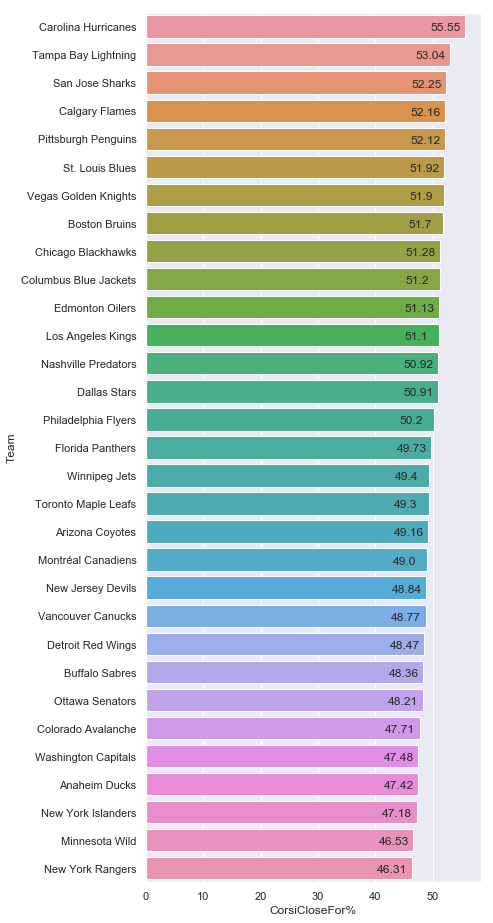

In [14]:
sns.set(rc={'figure.figsize':(6,16)})
ax = sns.barplot(x='CorsiCloseFor%', y='index', data=corsi_df.sort_values('CorsiCloseFor%', ascending=False).reset_index())
plt.ylabel('Team')
for i in range(len(ax.patches)):
    p = ax.patches[i]
    ax.annotate(corsi_df.sort_values('CorsiCloseFor%', ascending=False).iloc[i]['CorsiCloseFor%'], 
                xy = (p.xy[0]+p.get_width()-6, p.xy[1]+.55))

So we can calculate corsi close statistics for team. Unfortunatley, we cannot calculate corsi close as a percentage for players. But we can get corsi close totals and then use these statistics to rank the players. So while this isn't ideal it will give us some insight. (Ideally I will find some way to get data on what times players go on and off the ice in a game.)

In [15]:
def playerCorsiClose(playerID):
    conn = sqlite3.connect('myhockey.db')
    c = conn.cursor()
    c.execute("SELECT COUNT(*) FROM gameEvents WHERE playerID = ? AND score_diff IN (?,?) AND eventType IN (?, ?, ?, ?)", 
              ('{}'.format(playerID), '0', '1', 'Blocked Shot-Shooter', 'Shot-Shooter', 'Missed Shot-Shooter', 'Goal-Scorer' ,))
    total = c.fetchall()
        
    return int(total[0][0])

In [16]:
c.execute("SELECT playerID From players")
players = [i[0] for i in c.fetchall()]
corsi_dict = {}
for i in players:
    corsi_dict[i] = playerCorsiClose(i)
name_dict = {}
for i in players:
    c.execute("SELECT name FROM players WHERE playerID =?",(i,))
    name = c.fetchall()[0][0]
    name_dict[name]=i
playerCorsi_dict = {}
for i in name_dict.keys():
    playerCorsi_dict[i] = corsi_dict[name_dict[i]]
playerCorsi_df = pd.DataFrame.from_dict(playerCorsi_dict, orient='index', columns = ['CorsiCloseFor_Totals'])
playerCorsi_df = playerCorsi_df.sort_values('CorsiCloseFor_Totals', ascending=False)

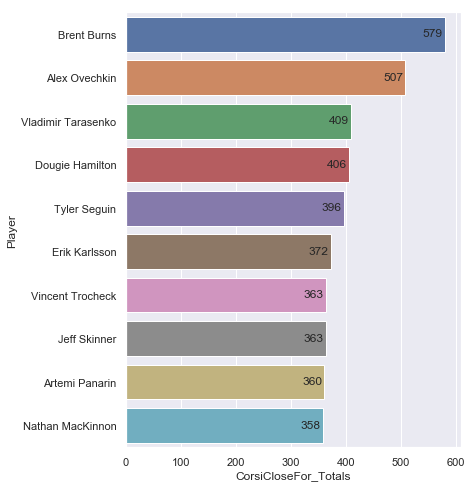

In [17]:
sns.set(rc={'figure.figsize':(6,8)})
ax = sns.barplot(x='CorsiCloseFor_Totals', y='index', data=playerCorsi_df.reset_index().head(10))
plt.ylabel('Player')
for i in range(len(ax.patches)):
    p = ax.patches[i]
    ax.annotate(playerCorsi_df.reset_index().head(10).iloc[i]['CorsiCloseFor_Totals'], 
                xy = (p.xy[0]+p.get_width()-40, p.xy[1]+.45))

## Next Steps

Now that the test implementation has been successful I will be creating an implementation with data for multiple seasons using MySQL on amazon web services. So I will need to adapt some of the code, but when I am done I will create a seperate jupyter notebook that contains an overview of what amazon web services I am using and the code to implement the database. 

As far as improvements to the database, one thing I definitely plan to add at some point is information about time on ice for players in a game. I also want to add an attribute to the gameEvents table that tracks whether play is at even strength and if not which team has the man advantage. Another thing I need to work on is the coordinate system the NHL uses. We have the location data but I am not sure what it means. Once I figure that out then I can use the data to calculate all sorts of different things, e.g. counts for scoring chances (which is a shot on goal from a particular area of the ice).